In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import jieba
import jieba.analyse
import math
from nltk import ngrams, FreqDist
from collections import Counter, namedtuple

import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.metrics.pairwise import cosine_similarity
import datetime

In [3]:
# 設定圖的中文字體 (無法顯示的話可以試試‘Microsoft JhengHei’字體)
# 也可參考：https://pyecontech.com/2020/03/27/python_matplotlib_chinese/
# plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] #使圖中中文能正常顯示
# plt.rcParams['axes.unicode_minus'] = False #使負號能夠顯示

In [4]:
# cloab 字體設定
import matplotlib

!wget -O taipei_sans_tc_beta.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

# 新增字體
matplotlib.font_manager.fontManager.addfont('taipei_sans_tc_beta.ttf')

# 將 font-family 設為 Taipei Sans TC Beta
# 設定完後，之後的圖表都可以顯示中文了
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2024-04-07 04:22:39--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 173.194.79.101, 173.194.79.100, 173.194.79.139, ...
Connecting to drive.google.com (drive.google.com)|173.194.79.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2024-04-07 04:22:40--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.119.132, 2a00:1450:4013:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.119.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘taipei_sans_tc_beta.ttf’

taipei_sans_tc_beta 100%[===================>]  19.70M  --.-KB/s    in 0.1s    

2024-04-07 04:22:42 

## 資料前處理

### 基本資料介紹
資料來源：
+ 工作流程平台蒐集PTT 旅日版(Japan_Travel)文章
+ 時間: 2023-06-01 ~ 2023-12-31
+ 資料筆數：共 6063 篇文章

In [5]:
#匯入資料
df = pd.read_csv('/content/drive/MyDrive/social_media_analysis/group_assignments/dataset_train.csv', encoding = 'UTF-8')
df["artDate"] = pd.to_datetime(df["artDate"])
df['artDate'] = df['artDate'].dt.date
df.head(3)

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artContent,artComment,e_ip,insertedDate,dataSource
0,1,https://www.ptt.cc/bbs/Aviation/M.1685574818.A...,Re:[新聞]韓亞航逃生門「飛一半被打開」 空姐「肉,2023-06-01,cici950630,Aviation,看到這新聞想到以前的飛行體驗\n那時候從德國要去iceland hofn i\n飛丹麥轉機時...,[],209.141.52.118,2023-06-02 01:02:07,ptt
1,2,https://www.ptt.cc/bbs/Aviation/M.1685581301.A...,[分享]長榮哩程機票兌換升等後補時間,2023-06-01,nanna,Aviation,今天八點半準時打長榮客服，聽了很多語音，按了很多按鍵後，\n 按9轉客服，完全沒有等到。\...,"[{""cmtStatus"": ""→"", ""cmtPoster"": ""abyssa1"", ""c...",118.163.43.79,2023-06-02 01:02:07,ptt
2,3,https://www.ptt.cc/bbs/Aviation/M.1685586987.A...,[分享]紐西蘭航空貴賓室皇后鎮國內線ZQN,2023-06-01,Furella,Aviation,圖文網誌版:\nhttps://bitesize.tw/2018-zqn-air-new-z...,[],118.167.224.229,2023-06-02 01:02:07,ptt


### 資料清理  
- 去除NA值
- 去除特殊字元與標點符號，只留下中文字
- \u4e00-\u9fff 為Unicode中文漢字字符的範圍

資料太多，全部用記憶體會不足，所以sample兩個月初來分析

In [6]:
MetaData = df[(df.artCatagory == 'Japan_Travel') & (df.artDate < datetime.date(2023, 8, 1))].copy()

# 去除一些不需要的欄位
MetaData = MetaData.drop(['artPoster', 'artComment', 'e_ip', 'insertedDate', 'dataSource'], axis=1)
# 只留下中文字
MetaData = MetaData.dropna(subset=['artContent'])
MetaData['sentence'] = MetaData['artContent'].apply(lambda x: re.sub('[^\u4e00-\u9fff]+', '',x))

MetaData.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...
1060,1061,https://www.ptt.cc/bbs/Japan_Travel/M.16855538...,[徵人][飯友]6/6-6/12富士/東京,2023-06-01,Japan_Travel,徵人類別:飯友\n\n 原po性別:男\n\n 徵 求:6/6-6/8會在富士山站...,徵人類別飯友原性別男徵求會在富士山站附近會在東京市區內容因為我行程都沒怎麼排所以想說揪人吃個...
1061,1062,https://www.ptt.cc/bbs/Japan_Travel/M.16855645...,[徵人][旅伴]6/06-6/08大阪燒肉,2023-06-01,Japan_Travel,徵人類別:不拘\n\n 原po性別:1男\n\n 徵 求:男女皆可\n\n 內 ...,徵人類別不拘原性別男徵求男女皆可內容自己一個人的大阪旅遊才發現要吃燒肉好像很難找自己一個人可...


### 文章斷詞與整理

In [7]:
# 設定繁體中文詞庫
jieba.set_dictionary('/content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big')

# 新增stopwords
with open('/content/drive/MyDrive/social_media_analysis/group_assignments/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

In [8]:
stopwords_manual = ["一些", "一份", "一台", "一圈", "一堆", "一定", "一家", "一人", "一天", "一小", "一大", "一帶", "一座", "一張", "一旁", "一日", "一早", "一晚", "一杯", "一條", "一次", "一段", "一種", "一起", "一趟", "一路", "一邊", "一間", "三個", "三天", "上次", "上面", "上方", "上點", "下來", "下去", "下方", "下次", "下面", "不到", "不太", "不知", "不算", "中間", "之前", "之外", "之間", "令人", "以來", "以前", "以外", "以為", "似乎", "來說", "像是", "先到", "兩個", "再次", "出現", "則是", "前方", "前面", "剛剛", "十分", "in", "XD", "一下", "一位", "一個", "一半", "一直", "一點", "下午", "不用", "主要", "之後", "今天", "今年", "今日", "他們", "以下", "以後", "來到", "入住", "內容", "出發", "分享", "前往", "包含", "包括", "可能", "吃到", "各位", "名稱", "回到", "因一", "因上", "地方", "好像", "完整", "就是", "層面", "左右", "年前", "年增", "建議", "感覺", "成為", "我們", "打打", "抵達", "持續", "指出", "提供", "搭配", "整個", "方面", "旁邊", "日期", "早上", "明天", "明年", "明日", "昨日", "是否", "晚上", "最後", "月底", "有", "有沒有", "有無", "東西", "決定", "沒", "沒有", "準備", "然後", "特別", "現在", "發現", "發生", "目前", "直接", "相關", "看到", "看看", "知道", "碰到", "維持", "聞到", "聽到", "表示", "裡面", "認為", "謝謝", "這", "這裡", "這間", "造成", "造訪", "進行", "過去", "那裡", "附近", "隔天", "離開", "需要", "顯示"]
stopWords.extend(stopwords_manual)

In [9]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選掉停用字與字元數小於1的詞彙

    return seg_list

In [10]:
MetaData = MetaData.copy()

# 斷詞、去除停用字並將word欄位展開
MetaData['word'] = MetaData.sentence.apply(getToken).explode('word')

MetaData.head(3)

Building prefix dict from /content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big ...
DEBUG:jieba:Building prefix dict from /content/drive/MyDrive/social_media_analysis/group_assignments/dict.txt.big ...
Dumping model to file cache /tmp/jieba.u7234afd41a7c8425b71c38621cb87694.cache
DEBUG:jieba:Dumping model to file cache /tmp/jieba.u7234afd41a7c8425b71c38621cb87694.cache
Loading model cost 4.722 seconds.
DEBUG:jieba:Loading model cost 4.722 seconds.
Prefix dict has been built successfully.
DEBUG:jieba:Prefix dict has been built successfully.


,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,服務態度
1060,1061,https://www.ptt.cc/bbs/Japan_Travel/M.16855538...,[徵人][飯友]6/6-6/12富士/東京,2023-06-01,Japan_Travel,徵人類別:飯友\n\n 原po性別:男\n\n 徵 求:6/6-6/8會在富士山站...,徵人類別飯友原性別男徵求會在富士山站附近會在東京市區內容因為我行程都沒怎麼排所以想說揪人吃個...,熱情
1061,1062,https://www.ptt.cc/bbs/Japan_Travel/M.16855645...,[徵人][旅伴]6/06-6/08大阪燒肉,2023-06-01,Japan_Travel,徵人類別:不拘\n\n 原po性別:1男\n\n 徵 求:男女皆可\n\n 內 ...,徵人類別不拘原性別男徵求男女皆可內容自己一個人的大阪旅遊才發現要吃燒肉好像很難找自己一個人可...,記憶


## 利用tf-idf找出重要詞彙

In [11]:
travel_df = MetaData.copy()
travel_df.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,服務態度
1060,1061,https://www.ptt.cc/bbs/Japan_Travel/M.16855538...,[徵人][飯友]6/6-6/12富士/東京,2023-06-01,Japan_Travel,徵人類別:飯友\n\n 原po性別:男\n\n 徵 求:6/6-6/8會在富士山站...,徵人類別飯友原性別男徵求會在富士山站附近會在東京市區內容因為我行程都沒怎麼排所以想說揪人吃個...,熱情
1061,1062,https://www.ptt.cc/bbs/Japan_Travel/M.16855645...,[徵人][旅伴]6/06-6/08大阪燒肉,2023-06-01,Japan_Travel,徵人類別:不拘\n\n 原po性別:1男\n\n 徵 求:男女皆可\n\n 內 ...,徵人類別不拘原性別男徵求男女皆可內容自己一個人的大阪旅遊才發現要吃燒肉好像很難找自己一個人可...,記憶


In [12]:
# 保留需要的欄位
travel_df = travel_df.loc[:,["system_id", "sentence"]]

# 改成使用空格連接斷完的詞
travel_df['word'] = travel_df.sentence.apply(getToken).map(' '.join)

travel_df.head()

,system_id,sentence,word
1059,1060,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,讓售 發文 門檻 次數 未達 門檻 主將 逕行 刪文 水桶 處理 讓售 品項 京都 鐵道 博...
1060,1061,徵人類別飯友原性別男徵求會在富士山站附近會在東京市區內容因為我行程都沒怎麼排所以想說揪人吃個...,徵人 類別 飯友原 性別 徵求 富士山 東京 市區 行程 當成 當天 行動 參考 備註 男女...
1061,1062,徵人類別不拘原性別男徵求男女皆可內容自己一個人的大阪旅遊才發現要吃燒肉好像很難找自己一個人可...,徵人 類別 性別 徵求 男女皆可 大阪 旅遊 燒肉 很難 可幫 出錢 備註 難波 內信 資訊
1062,1063,想請問有爬過文看到火腿隊新主場平常也可以進去參觀請問有營業時間限制嗎下禮拜要去北海道當天有比...,請問 過文 火腿 隊新 主場 平常 參觀 請問 營業時間 限制 下禮拜 北海道 當天 比賽 ...
1063,1064,造訪日期由於上次沒吃新潟著名的鄉土料理蒸氣麵包只好再過來一次而新潟的位置比較特別東西海岸有公...,著名 鄉土 料理 蒸氣 只好 過來 位置 海岸 公里 等於 半個 台灣 海岸線 看過 地圖 ...


In [13]:
# Bag of Word
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(travel_df["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成 dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一一,一一列舉,一丁,一丁點,一三五,一上,一上午,一下下,一下子,一下手,...,龜之井,龜之井高,龜井,龜城,龜山,龜崗,龜有,龜甲,龜裂,龜龜
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1695,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1696,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
transformer = TfidfTransformer()
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())

TFIDF_df

,一一,一一列舉,一丁,一丁點,一三五,一上,一上午,一下下,一下子,一下手,...,龜之井,龜之井高,龜井,龜城,龜山,龜崗,龜有,龜甲,龜裂,龜龜
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 檢視結果   
- 取每一個字詞在所有文件裡的TF-IDF平均值
- 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

#### 方法1： 取每一個字詞在所有文件裡的TF-IDF平均值

In [15]:
travel_tfidf = TFIDF_df.mean().to_frame().reset_index()
travel_tfidf.columns = ["word", "avg"]

travel_tfidf.sort_values('avg', ascending = False).head(10)

,word,avg
27707,行程,0.025515
33905,飯店,0.024342
18176,東京,0.022003
16774,日本,0.019837
28751,請問,0.019591
17137,時間,0.018613
18966,機場,0.017759
9764,大阪,0.017423
33605,預計,0.015175
2222,京都,0.014656


可以看到除了一些相關的地名之外，有一些跟交通相關的詞彙。可以推斷ptt的人大多多會在文章中提到交通相關的訊息。

#### 方法2： 取每份文件裡TF-IDF值最大的前10個字詞當為常用字詞，再取每一個字詞在常用字詞中出現頻率

In [16]:
toptens = TFIDF_df.copy()
toptens.insert(0, 'doc_id', toptens.index+1)

toptens

,doc_id,一一,一一列舉,一丁,一丁點,一三五,一上,一上午,一下下,一下子,...,龜之井,龜之井高,龜井,龜城,龜山,龜崗,龜有,龜甲,龜裂,龜龜
0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,1694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1694,1695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1695,1696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1696,1697,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
toptens = toptens.melt(id_vars = "doc_id", var_name = "word", value_name = 'tfidf')
toptens

,doc_id,word,tfidf
0,1,一一,0.0
1,2,一一,0.0
2,3,一一,0.0
3,4,一一,0.0
4,5,一一,0.0
...,...,...,...
59462257,1694,龜龜,0.0
59462258,1695,龜龜,0.0
59462259,1696,龜龜,0.0
59462260,1697,龜龜,0.0


nlargest() 會回傳指定列中最大的前x個值所對應的資料

In [18]:
(
    # 從每篇文章挑選出tf-idf最大的前十個詞
    toptens.groupby("doc_id").apply(lambda x : x.nlargest(10, "tfidf")).reset_index(drop=True)

    # 計算每個詞被選中的次數
    .groupby(['word'],as_index=False).size()

).sort_values('size', ascending=False).head(10) # 排序看前十名

,word,size
8262,飯店,97
658,京都,68
2628,大阪,66
5584,物品,62
6839,行程,61
7117,讓售,53
6054,福岡,51
1701,博多,50
4786,東京,49
2017,名古屋,46


由第二個方法的結果可以看出相比第一種方法多了一些日本的地名。

## 透過結巴斷詞與N-gram幫助建立斷詞字典
N-gram 指文本中連續出現的n個語詞。   
透過N-gram我們可以找出有哪些詞彙較常一起出現，檢查是否需要加入自定義字典中。   

### Bigram

In [19]:
# 設定 ngram 斷詞 function
def ngram_getToken(row, n):
    # 進行斷詞
    seg_list = jieba.lcut(row)

    # 篩選掉停用字與字元數小於1的詞彙
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1]

    # ngram斷詞
    seg_list = ngrams(seg_list, n)
    seg_list = [" ".join(w) for w in list(seg_list)]

    return seg_list

In [20]:
travel_bigram = MetaData.copy()

travel_bigram["word"] = travel_bigram['sentence'].apply(lambda row: ngram_getToken(row, 2))
travel_bigram = travel_bigram.explode('word')

travel_bigram.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,讓售 發文
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,發文 門檻
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,門檻 次數


#### 統計最常出現的bigram組合

In [21]:
# 計算每個組合出現的次數
travel_bigram_count = travel_bigram['word'].value_counts().reset_index()

travel_bigram_count.sort_values('count', ascending=False).head(50)

,word,count
0,成田 機場,144
1,每日 行程,140
2,環球 影城,125
3,關西 機場,119
4,東京 車站,103
5,徵人 類別,97
6,寄放 行李,88
7,聯絡 方式,84
8,京都 車站,83
9,方式 內信,82


### Trigram

In [22]:
travel_trigram = MetaData.copy()

travel_trigram["word"] = travel_trigram.sentence.apply(lambda row: ngram_getToken(row, 3))
travel_trigram = travel_trigram.explode('word')

travel_trigram.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,讓售 發文 門檻
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,發文 門檻 次數
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,門檻 次數 未達


#### 統計最常出現的trigram組合

In [23]:
# 計算每個組合出現的次數
travel_trigram_count = travel_trigram['word'].value_counts().reset_index()

travel_trigram_count.sort_values('count', ascending=False).head(30)

,word,count
0,聯絡 方式 內信,75
2,徵人 類別 旅伴,62
1,物品 買入 價格,62
3,類別 旅伴 性別,54
4,物品 圖片 物品,54
5,圖片 物品 買入,54
6,小於 等於 金額,50
7,買入 價格 讓售,50
8,只能 小於 等於,50
10,價格 讓售 只能,50


從上面的 bigram 和 trigram 的結果中，我們發現"成田 機場"、"環球 影城"等詞可以組合在一起，所以我們增加自定義字典來幫助斷詞能更準確。  
我們將詞彙整理好存在 dict 文件夾中的 buffet_lexicon.txt 中。

### 使用自建字典

In [24]:
# 新增吃到飽相關自定義字典
jieba.load_userdict('/content/drive/MyDrive/social_media_analysis/group_assignments/travel_lexicon.txt')

**使用自建辭典進行斷詞與計算**

In [25]:
# 剛才的斷詞結果沒有使用新增的辭典，因此我們重新進行斷詞
data2 = MetaData.copy()
data2['word'] = data2.sentence.apply(getToken)
data2 = data2.explode('word')

data2.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,讓售
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,發文
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,門檻


### Bigram視覺化

更新斷詞字典後重新進行bigram斷詞

In [26]:
bigramfdist = MetaData.copy()

bigramfdist["word"] = bigramfdist['sentence'].apply(lambda row: ngram_getToken(row, 2))
bigramfdist = bigramfdist.explode('word')

bigramfdist.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,讓售 發文
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,發文 門檻
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,門檻 次數


In [27]:
bigramfdist['word'] = bigramfdist['word'].astype(str)

# 使用FreqDist 取得 bigram 斷詞 與 bigram出現頻率
bigramfdist = FreqDist(bigramfdist['word'].apply(lambda x: tuple(x.split(' '))))
bigramfdist.most_common(20)

[(('每日', '行程'), 140),
 (('徵人', '類別'), 97),
 (('寄放', '行李'), 88),
 (('行程', '安排'), 82),
 (('買入', '價格'), 75),
 (('聯絡方式', '內信'), 75),
 (('讓售', '品項'), 71),
 (('物品', '圖片'), 70),
 (('欲售', '價格'), 70),
 (('台北', '桃園'), 69),
 (('哈利波', '影城'), 66),
 (('類別', '旅伴'), 63),
 (('物品', '買入'), 62),
 (('日圓', '日圓'), 60),
 (('鐵路', '周遊'), 58),
 (('旅伴', '性別'), 58),
 (('性別', '徵求'), 57),
 (('電話', '營業時間'), 56),
 (('圖片', '物品'), 54),
 (('地址', '東京都'), 53)]

In [28]:
# 建立bigram和count的dictionary
# 這裡取最多的前50項
d = {k:v for k,v in bigramfdist.most_common(50)}

In [29]:
# Create network plot
G = nx.Graph()

# 建立 nodes 間的連結
for k, v in [d][0].items():
    G.add_edge(k[0], k[1], weight=v) # nodes：詞彙，weight：組合出現頻率

# 取得edge權重
weights = [w[2]['weight']*0.01 for w in  G.edges(data=True)]

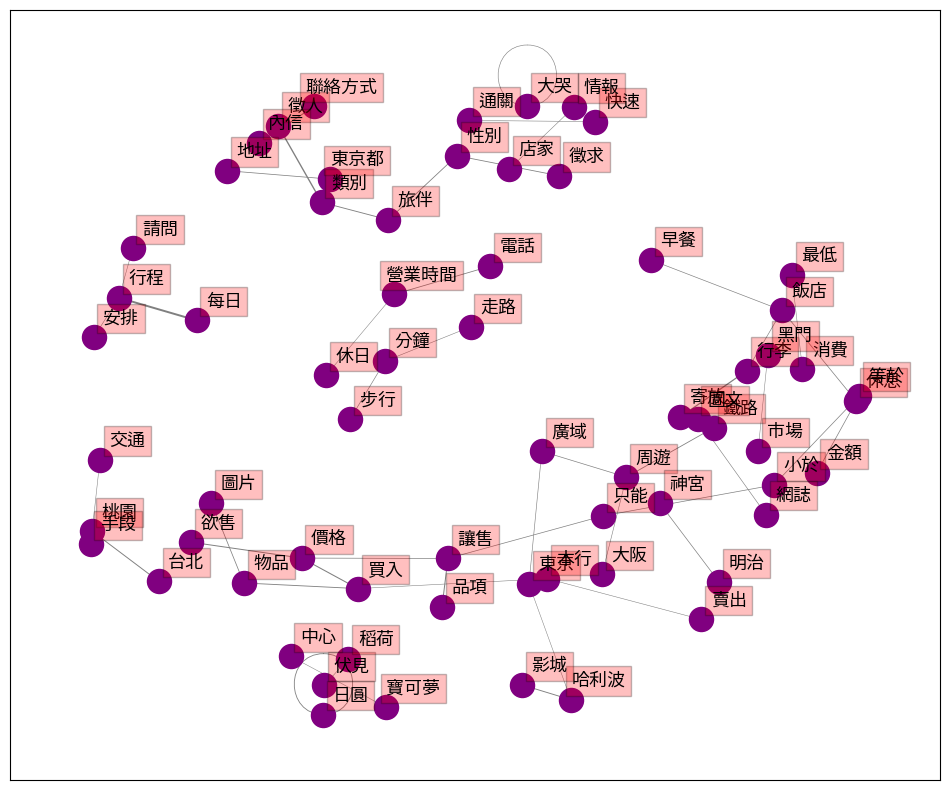

In [30]:
fig, ax = plt.subplots(figsize=(12, 10))

pos = nx.spring_layout(G, k=1.5)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)

plt.show()

## Pairwise correlation
計算兩個詞彙間的相關性 Pearson correlation

In [31]:
data_cor = MetaData.copy()

# 需要改成使用空格連接斷好的詞
data_cor['word'] = data_cor.sentence.apply(getToken).map(' '.join)
data_cor.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
1059,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,讓售 發文 門檻 次數 未達 門檻 主將 逕行 刪文 水桶 處理 讓售 品項 京都 鐵道 博...
1060,1061,https://www.ptt.cc/bbs/Japan_Travel/M.16855538...,[徵人][飯友]6/6-6/12富士/東京,2023-06-01,Japan_Travel,徵人類別:飯友\n\n 原po性別:男\n\n 徵 求:6/6-6/8會在富士山站...,徵人類別飯友原性別男徵求會在富士山站附近會在東京市區內容因為我行程都沒怎麼排所以想說揪人吃個...,徵人 類別 飯友原 性別 徵求 富士山 東京 市區 行程 當成 當天 行動 參考 備註 男女...
1061,1062,https://www.ptt.cc/bbs/Japan_Travel/M.16855645...,[徵人][旅伴]6/06-6/08大阪燒肉,2023-06-01,Japan_Travel,徵人類別:不拘\n\n 原po性別:1男\n\n 徵 求:男女皆可\n\n 內 ...,徵人類別不拘原性別男徵求男女皆可內容自己一個人的大阪旅遊才發現要吃燒肉好像很難找自己一個人可...,徵人 類別 性別 徵求 男女皆可 大阪 旅遊 燒肉 很難 可幫 出錢 備註 難波 內信 資訊


In [32]:
# Bag of Word
# 篩選至少出現在5篇文章以上且詞頻前300的詞彙
vectorizer = CountVectorizer(min_df = 5, max_features = 300)
X = vectorizer.fit_transform(data_cor["word"])
vocabulary = vectorizer.get_feature_names_out()

# 轉成dataframe
DTM_df = pd.DataFrame(columns = vocabulary, data = X.toarray())
DTM_df

,一日遊,上野,下車,不錯,中午,中央,中心,九州,交通,京都,...,類別,飛機,飯店,飲料,餐廳,體驗,高山,高松,鰻魚,麻煩
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1694,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1695,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1696,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# 計算詞之間的相關係數
corr_matrix = np.corrcoef(DTM_df.T)

# 轉成dataframe
Cor_df = pd.DataFrame(corr_matrix, index = DTM_df.columns, columns = DTM_df.columns)

Cor_df.insert(0, 'word1', Cor_df.columns)
Cor_df.reset_index(inplace = True, drop = True)

Cor_df

,word1,一日遊,上野,下車,不錯,中午,中央,中心,九州,交通,...,類別,飛機,飯店,飲料,餐廳,體驗,高山,高松,鰻魚,麻煩
0,一日遊,1.000000,0.053050,0.004091,0.026690,0.108288,-0.010794,0.030897,0.075921,0.056157,...,-0.042745,0.077534,0.065139,0.019322,0.002229,-0.017491,0.064952,0.041856,0.003801,0.163071
1,上野,0.053050,1.000000,0.003149,0.001044,0.076171,-0.003510,0.010536,-0.023206,0.084952,...,-0.047024,0.076466,0.208796,-0.002042,0.071855,0.008956,-0.019992,-0.010063,0.030213,0.102135
2,下車,0.004091,0.003149,1.000000,0.111399,0.039453,0.064176,0.135164,0.023233,0.213662,...,-0.045264,0.022389,0.034686,0.059348,0.050119,0.061969,0.057694,0.048396,-0.000290,-0.003262
3,不錯,0.026690,0.001044,0.111399,1.000000,0.138312,0.145353,0.121530,0.022603,0.054609,...,-0.023810,0.139567,0.241993,0.364477,0.256605,0.213107,0.024410,0.238005,0.104930,0.124872
4,中午,0.108288,0.076171,0.039453,0.138312,1.000000,0.041284,0.044889,0.076222,0.118457,...,-0.040353,0.128443,0.113104,0.137945,0.073769,0.084037,-0.005510,0.083760,-0.005021,0.068262
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,體驗,-0.017491,0.008956,0.061969,0.213107,0.084037,0.087259,0.016522,0.069416,0.075512,...,-0.042178,0.124930,0.092353,0.167336,0.462978,1.000000,0.003341,0.053263,0.067465,-0.010739
296,高山,0.064952,-0.019992,0.057694,0.024410,-0.005510,0.281644,0.013829,0.000602,0.220417,...,-0.024691,0.016730,0.028582,-0.017787,0.007573,0.003341,1.000000,0.106978,-0.006986,0.069520
297,高松,0.041856,-0.010063,0.048396,0.238005,0.083760,0.223486,0.028053,-0.004671,0.093057,...,-0.019707,0.069775,0.121164,0.127458,0.051630,0.053263,0.106978,1.000000,0.016361,0.202546
298,鰻魚,0.003801,0.030213,-0.000290,0.104930,-0.005021,-0.001683,0.000989,0.076718,0.012351,...,-0.017721,-0.002924,0.011120,0.011976,0.072420,0.067465,-0.006986,0.016361,1.000000,0.012702


In [34]:
word_cor_df = Cor_df.melt(id_vars = 'word1', var_name = 'word2', value_name = 'cor')

# 去除兩個詞相同的情況
word_cor_df = word_cor_df[word_cor_df["word1"] != word_cor_df["word2"]]

word_cor_df.sort_values('cor', ascending=False).head(10)

,word1,word2,cor
87110,徵人,類別,0.918525
33290,類別,徵人,0.918525
21784,營業時間,地址,0.885958
55272,地址,營業時間,0.885958
13175,長崎,原爆,0.876607
82543,原爆,長崎,0.876607
33114,性別,徵人,0.874917
34310,徵人,性別,0.874917
34311,徵求,性別,0.869735
33414,性別,徵求,0.869735


### 和 「東京」, 「迪士尼」 相關性最高的 10 個詞彙

In [35]:
tokyo_sum = word_cor_df[(word_cor_df["word1"] == "東京")].sort_values(by = ['cor'], ascending = False).head(10)
disney_sum = word_cor_df[(word_cor_df["word1"] == "迪士尼")].sort_values(by = ['cor'], ascending = False).head(10)

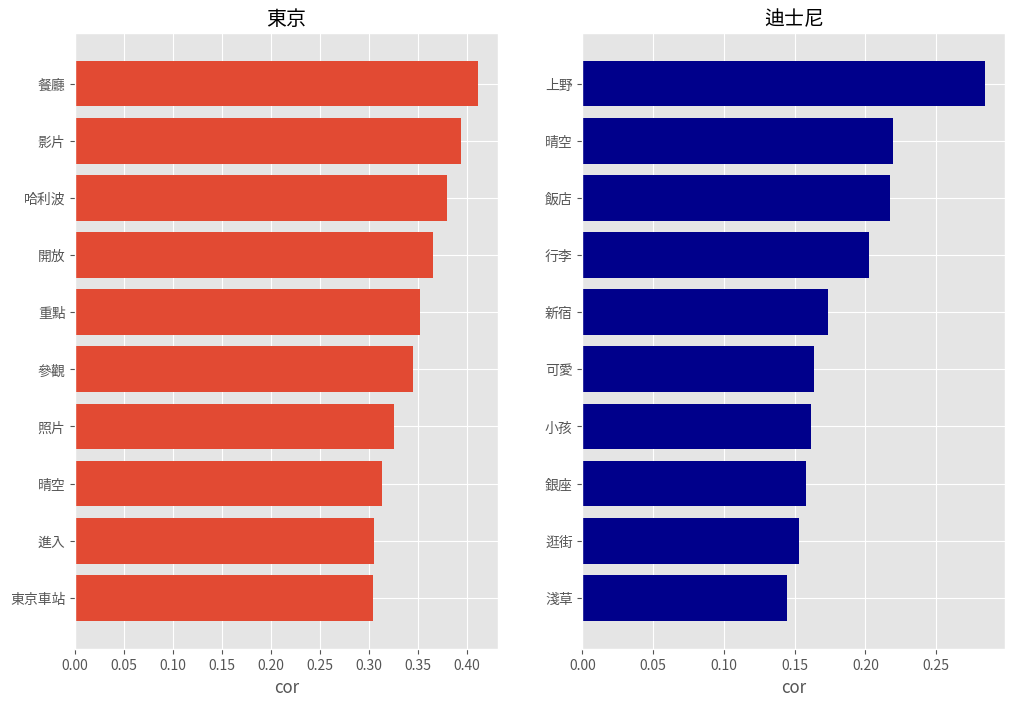

In [36]:
plt.figure(figsize=(12,8))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

plt.subplot(121)
plt.title('東京')
plt.xlabel('cor')
plt.barh(tokyo_sum['word2'], tokyo_sum['cor'])
plt.gca().invert_yaxis()

plt.subplot(122)
plt.title('迪士尼')
plt.xlabel('cor')
plt.barh(disney_sum['word2'], disney_sum['cor'],color="darkblue")
plt.gca().invert_yaxis()

plt.show()

由這張圖可以看出，和東京相關性高的詞彙有包含交通和觀光方面的。迪士尼的部分則是跟附近的地名相關居多。

### 使用詞彙關係圖畫出以詞頻前60為節點且相關性高於0.3的組合

In [37]:
# 透過DTM找出詞頻前60高的詞彙
most_freq_df = DTM_df.sum().sort_values(ascending=False).head(60).reset_index().rename(columns={'index':'word', 0:'count'})

most_freq_word = most_freq_df['word'].tolist()

In [38]:
# 保留存在詞頻前60高之詞彙的組合
filtered_df = word_cor_df[(word_cor_df['word1'].isin(most_freq_word)) & (word_cor_df['word2'].isin(most_freq_word))]

# 篩選出相關係數大於0.3的組合
filtered_df = filtered_df[filtered_df['cor'] > 0.3]
filtered_df.reset_index(inplace=True, drop=True)
filtered_df

,word1,word2,cor
0,分鐘,不錯,0.321723
1,商店,不錯,0.352398
2,喜歡,不錯,0.518010
3,好吃,不錯,0.579288
4,推薦,不錯,0.417401
...,...,...,...
147,體驗,餐廳,0.462978
148,拍照,體驗,0.313125
149,時間,體驗,0.360089
150,購買,體驗,0.360629


In [39]:
# Create network plot
g = nx.Graph()

# 建立 nodes 間的連結
for i in range(len(filtered_df)):
    g.add_edge(filtered_df["word1"][i], filtered_df["word2"][i], weight=filtered_df["cor"][i])

# 取得edge權重
weights = [w[2]['weight']*1 for w in  g.edges(data=True)]

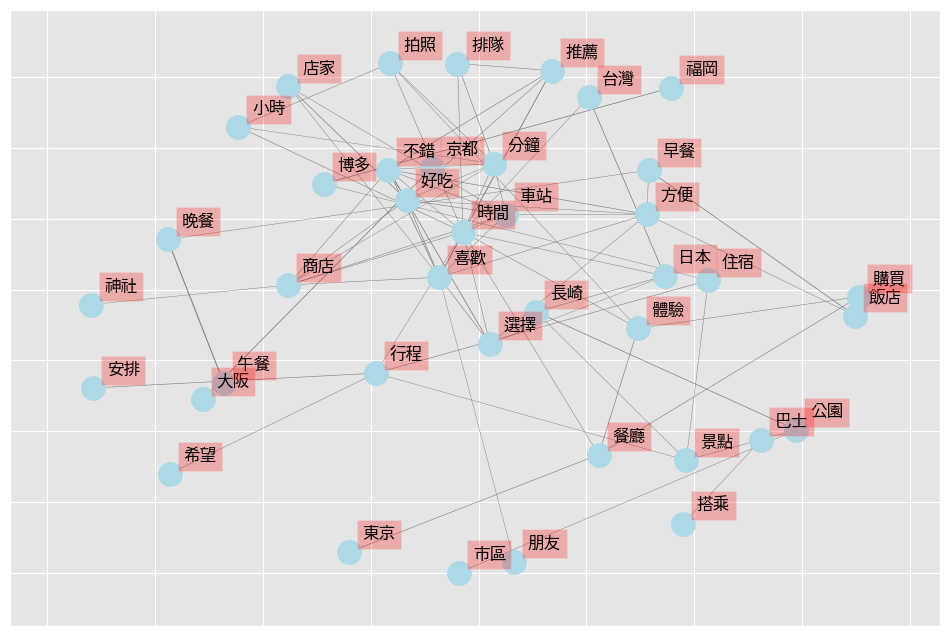

In [40]:
fig, ax = plt.subplots(figsize=(12, 8))

pos = nx.spring_layout(g, k=0.8)

# networks
nx.draw_networkx(g, pos,
                 font_size=16,
                 width=weights,
                 edge_color='grey',
                 node_color='lightblue',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=12)

plt.show()

由這張圖可以看到飯店跟早餐和餐廳一起出現的次數蠻多的，可能代表ptt的人在提到住宿的同時，也都會注意到其飲食。

## 計算文章相似度
以TF-IDF的結果當作文章的向量，計算 Cosine Similarity 找出相似的文章   

<img src="./img/pic3.PNG" style="float:left;" width="50%">  

In [41]:
data_cos = data_cor.copy()
data_cos = data_cos.reset_index()
data_cos = data_cos.drop(['index'], axis = 1)
data_cos.head(3)

,system_id,artUrl,artTitle,artDate,artCatagory,artContent,sentence,word
0,1060,https://www.ptt.cc/bbs/Japan_Travel/M.16855511...,[讓售]京都鐵道博物館一大一小,2023-06-01,Japan_Travel,（讓售文發文門檻為上站次數 365 以上，未達門檻者板主將逕行刪文或水桶處理）\n\n1. ...,讓售文發文門檻為上站次數以上未達門檻者板主將逕行刪文或水桶處理讓售品項京都鐵道博物館一大一小...,讓售 發文 門檻 次數 未達 門檻 主將 逕行 刪文 水桶 處理 讓售 品項 京都 鐵道 博...
1,1061,https://www.ptt.cc/bbs/Japan_Travel/M.16855538...,[徵人][飯友]6/6-6/12富士/東京,2023-06-01,Japan_Travel,徵人類別:飯友\n\n 原po性別:男\n\n 徵 求:6/6-6/8會在富士山站...,徵人類別飯友原性別男徵求會在富士山站附近會在東京市區內容因為我行程都沒怎麼排所以想說揪人吃個...,徵人 類別 飯友原 性別 徵求 富士山 東京 市區 行程 當成 當天 行動 參考 備註 男女...
2,1062,https://www.ptt.cc/bbs/Japan_Travel/M.16855645...,[徵人][旅伴]6/06-6/08大阪燒肉,2023-06-01,Japan_Travel,徵人類別:不拘\n\n 原po性別:1男\n\n 徵 求:男女皆可\n\n 內 ...,徵人類別不拘原性別男徵求男女皆可內容自己一個人的大阪旅遊才發現要吃燒肉好像很難找自己一個人可...,徵人 類別 性別 徵求 男女皆可 大阪 旅遊 燒肉 很難 可幫 出錢 備註 難波 內信 資訊


In [42]:
transformer = TfidfTransformer()
print(transformer)
# 將詞頻矩陣X統計成TF-IDF值
tfidf = transformer.fit_transform(X)

# 轉成dataframe
TFIDF_df = pd.DataFrame(columns = vocabulary, data = tfidf.toarray())
TFIDF_df

TfidfTransformer()


,一日遊,上野,下車,不錯,中午,中央,中心,九州,交通,京都,...,類別,飛機,飯店,飲料,餐廳,體驗,高山,高松,鰻魚,麻煩
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.168053,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.239002,0.000000,...,0.302800,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.355662,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.156237,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.130511,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1693,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1694,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1695,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.174784,0.000000,...,0.000000,0.0,0.141856,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
1696,0.0,0.0,0.0,0.0,0.0,0.0,0.151773,0.0,0.000000,0.000000,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


計算文章間的cosine similarity

In [43]:
cosine_matrix = cosine_similarity(tfidf.toarray(), tfidf.toarray())

檢視與第一篇文章相似的文章

In [44]:
cos_df = pd.DataFrame(cosine_matrix[4], columns = ['cos_similarity'])
cos_df

,cos_similarity
0,0.000000
1,0.000000
2,0.000000
3,0.000000
4,1.000000
...,...
1693,0.000000
1694,0.000000
1695,0.020557
1696,0.040617


In [45]:
cos_df = cos_df.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
4,1.000000,[遊記]5/15新潟-秋田乳頭溫泉,https://www.ptt.cc/bbs/Japan_Travel/M.16855733...
873,0.429091,[遊記]兩天一夜田沢湖、乳頭溫泉鄉之旅流水帳,https://www.ptt.cc/bbs/Japan_Travel/M.16883027...
1399,0.377267,沖繩 逸之彩溫泉度假飯店,https://www.ptt.cc/bbs/Japan_Travel/M.16898378...
20,0.362701,[住宿]銀山温泉八室の宿藤屋,https://www.ptt.cc/bbs/Japan_Travel/M.16856048...
994,0.357288,[問題]秀峰閣湖月請益,https://www.ptt.cc/bbs/Japan_Travel/M.16886361...
1376,0.343831,[遊記]日本‧白川鄉｜合掌村一日散策紀行,https://www.ptt.cc/bbs/Japan_Travel/M.16897762...
1140,0.343091,［贈票］7/13日別府灶門地獄門票兩張,https://www.ptt.cc/bbs/Japan_Travel/M.16890860...
604,0.331976,[食記]仙台的雞湯拉麵：仙台中華そば嘉一,https://www.ptt.cc/bbs/Japan_Travel/M.16874336...
342,0.316887,[心得]九州極簡旅遊手冊分享,https://www.ptt.cc/bbs/Japan_Travel/M.16865806...
911,0.305609,[遊記]新潟市區閒晃與新潟東橫INN,https://www.ptt.cc/bbs/Japan_Travel/M.16884294...


第5篇文章主要是在分享新瀉和秋田乳頭溫泉的相關心得，所以可以看到相關的文章也大多都是和溫泉有關

檢視與第16篇文章相似的文章

In [46]:
cos_df_16 = pd.DataFrame(cosine_matrix[15], columns=['cos_similarity'])

cos_df_16 = cos_df_16.merge(data_cos, how = 'left', left_index=True, right_index=True)
cos_df_16.loc[:,["cos_similarity", "artTitle", "artUrl"]].sort_values(by=['cos_similarity'], ascending=False).head(10)

,cos_similarity,artTitle,artUrl
15,1.000000,[食記]沖繩牧志市場-Dotonbori道頓堀愛吃海鮮必訪,https://www.ptt.cc/bbs/Japan_Travel/M.16855952...
1068,0.604908,[食記]豬肉蛋飯糰北谷店牛排炸蝦塔塔醬,https://www.ptt.cc/bbs/Japan_Travel/M.16889049...
106,0.594145,[食記]沖繩宮古島の雪塩雪鹽冰淇淋,https://www.ptt.cc/bbs/Japan_Travel/M.16858811...
1598,0.570540,[食記]東京池袋魚河岸鮪魚市場,https://www.ptt.cc/bbs/Japan_Travel/M.16904786...
526,0.506454,[遊記]沖繩道の駅許田便宜熱門觀光景點門票,https://www.ptt.cc/bbs/Japan_Travel/M.16871830...
219,0.459376,Fw:[食記]沖繩10円パン起司牽絲超過30cm,https://www.ptt.cc/bbs/Japan_Travel/M.16862320...
1153,0.439855,[贈送]沖繩海洋館票QRcode,https://www.ptt.cc/bbs/Japan_Travel/M.16891316...
681,0.424070,[食記]沖繩乳牛冰淇淋生乳製作濃郁牛奶味,https://www.ptt.cc/bbs/Japan_Travel/M.16877022...
618,0.419120,[食記]富山縣富山車站西町大喜黑拉麵,https://www.ptt.cc/bbs/Japan_Travel/M.16874547...
1399,0.417761,沖繩 逸之彩溫泉度假飯店,https://www.ptt.cc/bbs/Japan_Travel/M.16898378...


第16篇文章主要是分享沖繩牧志市場食物相關的心得，所以相關的文章看起也都是和食物有關的